<a href="https://colab.research.google.com/github/vithushanms/.NET5_GraphQL/blob/main/%5BLanguage_Models%5D_makemore_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [119]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [120]:
#if cloud
from google.colab import drive
drive.mount('/content/drive')
dataFilePath = '/content/drive/My Drive/Publications/Neural Networks Research/makemore: next char prediction language model/names.txt'
words = open(dataFilePath, 'r').read().splitlines() 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [121]:
len(words)

32033

In [122]:
# encode chars in the words to integer
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [123]:
[0] * 3

[0, 0, 0]

In [124]:
# build the dataset

'''
build the dataset while having the block_size (the number of chars we are going to input at a time) as 3
'''
block_size = 3 
X, Y = [], []
for w in words[:5]:
  print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix]
  
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


X.shape = 32, 3 as the number of inputs are 32 and each have 3 charector input
Y.shape = 32, 1 as the number of outcome are 32 and for each respective inputs of 3 charactor there will be one output

As a next step we should encode the dataset X to some sort of format that should be light weight at the same time have the context. 

If we use the one hot encoding this would work for this particular case as it's only 27 distinct charecter we have in our dataset. but if we take large language models posibily there would be more than a billion distict words makes that diemention to the input set. Therefore we need to scale it down to a smaller diemention without loosing the quality of the prediction. So for that and the following reasons we should scale down the data.

*   Sparsity: One-hot encoded vectors are sparse, with only one element being 1 and the rest being 0. This can lead to high memory usage, especially for large vocabularies, as each word requires a vector of the size of the vocabulary.
*   Computational complexity: Since one-hot encoded vectors are high-dimensional, matrix multiplications and other operations in the model become computationally expensive. By reducing the dimensionality, you can significantly speed up training and inference.
* No semantic information: One-hot encoded vectors don't capture any semantic relationships between words, as they are orthogonal to each other. Word embeddings, on the other hand, are dense vector representations that capture semantic relationships, making it easier for the model to learn and generalize from the data.
* Poor generalization: One-hot encoding does not support handling out-of-vocabulary words or handling new words that were not seen during training. Word embeddings can help in this regard by generating embeddings for previously unseen words based on their morphological or contextual similarities to known words.
* Difficulty in capturing context: One-hot encoded vectors don't capture context information effectively. Word embeddings, especially when used in combination with more advanced techniques like transformers, can capture long-range dependencies and contextual information, enabling the model to better understand and generate coherent sequences of text.



In [125]:
# we can use the matrix multiplication to scale it down. ex (32,27) * (27,2) = (32,2) 
#Also this is going to be the first layer / input layer of the MLP
C = torch.rand(27,2, requires_grad=True)
#example with a one hot encoding of 5
five_en = torch.nn.functional.one_hot(torch.tensor(5), num_classes=27).float()
(five_en @ C)

tensor([0.6811, 0.2403], grad_fn=<SqueezeBackward3>)

In [126]:
#apperently this is same as what we are going to get by the integer representation itself|
C[5]

tensor([0.6811, 0.2403], grad_fn=<SelectBackward0>)

So we can dierectly use indexing here

In [127]:
# we can index the whole data set at one go
C[X].shape

torch.Size([32, 3, 2])

This is resulting with 32, 3, 2 because we have 32 lines of inputs and each input has 3 character and each character is encoded to 2 diemention instead of 27

In [128]:
emb = C[X]

But at some point we need to concatinate the 3 character encodings as we need to pass them all together to the inputs to next layer of the model

In [129]:
# we can use torch.cat
torch.cat([emb[: , 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1).shape

torch.Size([32, 6])

In [130]:
# we can use view which is the most efficent way
emb.view(32,6).shape

torch.Size([32, 6])

view() is used to reshape a tensor without altering its underlying data. It returns a new tensor with the specified dimensions that shares the same data with the original tensor. The primary goal of view() is to change the dimensions of a tensor to match the input or output requirements of neural network layers or other operations.

torch.cat() is used to concatenate multiple tensors along a specified dimension. This operation combines the input tensors into a single larger tensor, effectively "stacking" them along the chosen axis. The input tensors must have the same shape along all dimensions except for the one being concatenated.

However in this spesific scenario the data arrangement is going to the same in both the cases as we are effectivly slicing the input. But view is slightly efficent as it's just a reshape operation performed in the same tensor rather than creating a tensor and copying the data to the new diemension in torch.cat

In [131]:
torch.cat([emb[: , 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1)

tensor([[0.1728, 0.5642, 0.1728, 0.5642, 0.1728, 0.5642],
        [0.1728, 0.5642, 0.1728, 0.5642, 0.6811, 0.2403],
        [0.1728, 0.5642, 0.6811, 0.2403, 0.9375, 0.1382],
        [0.6811, 0.2403, 0.9375, 0.1382, 0.9375, 0.1382],
        [0.9375, 0.1382, 0.9375, 0.1382, 0.2328, 0.6608],
        [0.1728, 0.5642, 0.1728, 0.5642, 0.1728, 0.5642],
        [0.1728, 0.5642, 0.1728, 0.5642, 0.7800, 0.8583],
        [0.1728, 0.5642, 0.7800, 0.8583, 0.7092, 0.9799],
        [0.7800, 0.8583, 0.7092, 0.9799, 0.9501, 0.9993],
        [0.7092, 0.9799, 0.9501, 0.9993, 0.9483, 0.6973],
        [0.9501, 0.9993, 0.9483, 0.6973, 0.9501, 0.9993],
        [0.9483, 0.6973, 0.9501, 0.9993, 0.2328, 0.6608],
        [0.1728, 0.5642, 0.1728, 0.5642, 0.1728, 0.5642],
        [0.1728, 0.5642, 0.1728, 0.5642, 0.2328, 0.6608],
        [0.1728, 0.5642, 0.2328, 0.6608, 0.9483, 0.6973],
        [0.2328, 0.6608, 0.9483, 0.6973, 0.2328, 0.6608],
        [0.1728, 0.5642, 0.1728, 0.5642, 0.1728, 0.5642],
        [0.172

In [132]:
emb.view(32,6)

tensor([[0.1728, 0.5642, 0.1728, 0.5642, 0.1728, 0.5642],
        [0.1728, 0.5642, 0.1728, 0.5642, 0.6811, 0.2403],
        [0.1728, 0.5642, 0.6811, 0.2403, 0.9375, 0.1382],
        [0.6811, 0.2403, 0.9375, 0.1382, 0.9375, 0.1382],
        [0.9375, 0.1382, 0.9375, 0.1382, 0.2328, 0.6608],
        [0.1728, 0.5642, 0.1728, 0.5642, 0.1728, 0.5642],
        [0.1728, 0.5642, 0.1728, 0.5642, 0.7800, 0.8583],
        [0.1728, 0.5642, 0.7800, 0.8583, 0.7092, 0.9799],
        [0.7800, 0.8583, 0.7092, 0.9799, 0.9501, 0.9993],
        [0.7092, 0.9799, 0.9501, 0.9993, 0.9483, 0.6973],
        [0.9501, 0.9993, 0.9483, 0.6973, 0.9501, 0.9993],
        [0.9483, 0.6973, 0.9501, 0.9993, 0.2328, 0.6608],
        [0.1728, 0.5642, 0.1728, 0.5642, 0.1728, 0.5642],
        [0.1728, 0.5642, 0.1728, 0.5642, 0.2328, 0.6608],
        [0.1728, 0.5642, 0.2328, 0.6608, 0.9483, 0.6973],
        [0.2328, 0.6608, 0.9483, 0.6973, 0.2328, 0.6608],
        [0.1728, 0.5642, 0.1728, 0.5642, 0.1728, 0.5642],
        [0.172

A Multilayer Perceptron (MLP) is a type of artificial neural network that can be used for language modeling tasks. The following are some of the hyperparameters that can be adjusted in an MLP for language modeling:

1. Architecture: The number of hidden layers and the number of neurons in each layer can be adjusted. Increasing the number of hidden layers and neurons can increase the capacity of the model, but also increase the risk of overfitting.

2. Activation Function: The activation function used in each layer can be adjusted. Common choices include ReLU, sigmoid, and tanh.

3. Learning Rate: The learning rate determines the step size used to update the model's parameters during training. A too-high learning rate can cause the model to converge slowly or not at all, while a too-low learning rate can cause the model to converge too slowly.

4. Momentum: Momentum is a hyperparameter used in gradient descent optimization algorithms to speed up convergence. It adds a fraction of the update vector of the past time step to the current update vector.

5. Regularization: Regularization is a technique used to prevent overfitting by adding a penalty term to the loss function. Common choices include L1 and L2 regularization, and dropout.

6. Batch Size: The batch size determines the number of samples used in one iteration of training. Larger batch sizes can lead to faster training, but may also require more memory.

7. Epochs: The number of training epochs determines how many times the model will see the entire training dataset. More epochs can lead to better model performance, but also increase the risk of overfitting.

These are some of the most common hyperparameters that can be adjusted in an MLP for language modeling. The optimal values for these hyperparameters depend on the specific task and dataset, and often require experimentation to determine.

These hyperparameter can be optimized mostly by the trial and errors during the training 

In [105]:
#create hidden layer. having 100 neurons initially and adding tanh as an activation function
W1 = torch.randn((6,100), requires_grad=True)
b = torch.randn(100, requires_grad=True)
out_1 = emb.view(32,6) @ W1 + b
out_h = torch.tanh(out_1)

In [106]:
out_h.shape

torch.Size([32, 100])

In [107]:
#create final layer. we are using the softmax for activation function as the expecation to get a probability of each character in 27
W2 = torch.randn((100,27) , requires_grad=True)
b2 = torch.randn(27, requires_grad=True)
logits = out_h @ W2 + b2  
#perform softmax
counts = torch.exp(logits)
counts.shape
prob = counts / counts.sum(1, keepdim=True)

Emphasize differences: Exponentiating logits makes the differences between large and small logits more pronounced, causing the softmax function to produce more distinct probabilities. This property is helpful in tasks like classification, where you want the model to be more confident in its predictions.

Non-negative probabilities: Exponentiating logits ensures that the resulting probabilities are non-negative, as the exponential function e^x is always positive for any x. This is important because probabilities should always be non-negative by definition.

Normalization: After exponentiating logits, they are normalized by dividing each exponentiated logit by the sum of all exponentiated logits. This normalization step ensures that the resulting probabilities sum up to 1, which is a requirement for a valid probability distribution.

In [108]:
prob.shape

torch.Size([32, 27])

In [109]:
for i in range(len(Y[:2])):
  iy = Y[i].item()
  print(f'---- y actual : {itos[iy]} --> {iy} ')
  print('---- predicted probabilities : ', prob[i])
  print(f'---- predicted probability of {itos[iy]} {prob[i][iy]} ')

---- y actual : e --> 5 
---- predicted probabilities :  tensor([7.6692e-05, 4.2762e-02, 1.6194e-04, 7.5072e-08, 4.6627e-01, 7.9406e-05,
        3.2504e-02, 5.2626e-09, 2.7080e-01, 1.6396e-07, 1.3619e-05, 7.2042e-04,
        1.0136e-04, 1.1874e-07, 4.1913e-07, 1.8226e-01, 1.3920e-06, 3.2976e-06,
        4.4810e-06, 4.7982e-09, 3.4682e-05, 6.7459e-08, 5.8284e-08, 2.1400e-05,
        5.1962e-06, 3.9390e-12, 4.1876e-03], grad_fn=<SelectBackward0>)
---- predicted probability of e 7.940554496599361e-05 
---- y actual : m --> 13 
---- predicted probabilities :  tensor([2.8837e-02, 2.0960e-01, 3.2999e-04, 2.3308e-07, 6.0434e-01, 2.7638e-06,
        3.3091e-04, 6.0075e-09, 6.5271e-03, 1.8370e-07, 4.5106e-06, 6.1224e-03,
        1.2553e-04, 9.0463e-10, 5.3147e-07, 1.4123e-01, 6.6871e-09, 4.2949e-07,
        3.7239e-06, 1.0615e-10, 1.2857e-04, 1.5257e-10, 1.5976e-06, 5.8359e-05,
        2.5933e-07, 9.5356e-12, 2.3507e-03], grad_fn=<SelectBackward0>)
---- predicted probability of m 9.046257076761

In [110]:
#get the probability of y act from all the respective 32 input feature set 
prob[torch.arange(32), Y]

tensor([7.9406e-05, 9.0463e-10, 2.6306e-09, 2.5379e-02, 1.0564e-07, 1.8226e-01,
        4.3930e-05, 6.3609e-08, 7.3472e-08, 1.0054e-08, 1.9696e-02, 4.1512e-03,
        4.2762e-02, 1.5871e-06, 2.1677e-01, 5.4982e-04, 1.6396e-07, 3.3729e-11,
        9.5087e-01, 1.7362e-04, 2.6468e-07, 1.0213e-05, 4.0064e-05, 1.2164e-02,
        1.7735e-04, 4.7982e-09, 6.1455e-03, 1.6214e-06, 4.8349e-05, 2.3233e-09,
        4.5359e-03, 8.3696e-07], grad_fn=<IndexBackward0>)

In [111]:
#calculate the log likelyhood which is the loss
loss = nll = -prob[torch.arange(32),Y].log().mean() 
loss

tensor(11.0280, grad_fn=<NegBackward0>)

In [114]:
#parameter of the model
parameters = [C, W1, b, W2, b2]
sum(p.nelement() for p in parameters)

3481

cross_entropy is a built in feature within the pytorch that calculates the negative log likelyhood againt the Y actual after performing the softmax from the given logits. and as it's inbuilt, this is much more effiecent to use

In [115]:
#there is an internal impl in pytourch which calculates the loss directly
loss = F.cross_entropy(logits, Y)
loss

tensor(11.0280, grad_fn=<NllLossBackward0>)

In [116]:
#backpropogate and tune the model
for i in range(10):
  #forward
  emb = C[X]
  out_1 = emb.view(-1,6) @ W1 + b
  out_h = torch.tanh(out_1)
  logits = out_h @ W2 + b2  
  loss = F.cross_entropy(logits, Y)
  #backward
  for p in parameters:
    p.grad = None
  loss.backward()
  #update
  for p in parameters:
    p.data += -0.5 * p.grad

loss

tensor(2.6876, grad_fn=<NllLossBackward0>)

So far we have tried with only first five names from the data set. so let's try the same approach with the whole data set

In [135]:
X, Y = [], []

for name in words:
  context = [0] * 3
  for ch in name + '.':
    ix = stoi[ch]
    Y.append(ix)
    X.append(context)
    context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)


Why do we use tensors instead of normal array

1. Efficient computation on GPUs: torch.Tensor has built-in support for GPU acceleration, which makes it much faster than standard multidimensional arrays when performing computationally intensive operations. This is especially important in machine learning, where large amounts of data need to be processed quickly.

2. Automatic differentiation: torch.Tensor supports automatic differentiation, which is a key feature for training neural networks using techniques like backpropagation. Automatic differentiation allows you to easily calculate gradients of complex functions, which is essential for optimizing model parameters.

3. Extensive library support: torch.Tensor is part of the PyTorch library, which has extensive support for machine learning and scientific computing. PyTorch includes many useful tools for building and training neural networks, such as built-in loss functions, optimizers, and activation functions.

4. Flexible data types: torch.Tensor supports a wide range of data types, including floating-point numbers, integers, and Boolean values. This flexibility makes it easy to work with different types of data, which is important in many scientific and engineering applications.

In [195]:
C = torch.randn((27,2),requires_grad=True)
W1 = torch.randn((6,100), requires_grad=True)
b1 = torch.randn(100, requires_grad=True)
W2 = torch.randn((100, 27), requires_grad=True)
b2 = torch.randn(27, requires_grad=True)
parameters = [C, W1, b1, W2, b2]

In [196]:
emb = C[X]
out_h = (emb.view(-1, 6) @ W1 + b1).tanh()
logits = out_h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(16.0425, grad_fn=<NllLossBackward0>)

In [197]:
for i in range(10):
  #forward pass
  emb = C[X]
  logits = ((emb.view(-1,6) @ W1 + b1).tanh()) @ W2 + b2
  loss = F.cross_entropy(logits, Y)

  #backward
  for p in parameters:
    p.grad = None
  loss.backward()

  #tune the parameters
  for p in parameters:
    p.data += -0.1 * p.grad

In [198]:
loss.item()

8.699881553649902

Choosing a good learning rate is a critical step when training a Multilayer Perceptron (MLP) using backpropagation. Here are some methods to determine a better learning rate:
--

1. Grid Search: Grid search is a simple but effective way to find a good learning rate. In this method, you specify a range of learning rates and train the MLP with each learning rate in the range. You can then evaluate the performance of the model for each learning rate and choose the one that performs best.

2. Learning Rate Range Test: The learning rate range test is a more automated way to determine a good learning rate. In this method, you start with a very small learning rate and increase it exponentially while training the model. You can then plot the loss as a function of learning rate and choose the value at which the loss starts to decrease the most rapidly. This method can help you find a good learning rate quickly and without much manual effort.

3. Adaptive Learning Rates: Adaptive learning rate methods, such as Adam and Adagrad, adjust the learning rate automatically during training based on the gradients of the loss function. These methods can be more effective than manually tuning the learning rate, as they can adapt to the specific characteristics of the problem being solved.

4. Learning Rate Schedules: Learning rate schedules adjust the learning rate over time, typically reducing it as training progresses. Commonly used learning rate schedules include step decay, where the learning rate is reduced by a fixed factor after a certain number of epochs, and exponential decay, where the learning rate is reduced exponentially over time. These methods can help prevent the learning rate from becoming too large during later stages of training, when the gradients are smaller.

Overall, choosing a good learning rate can be a bit of an art, and it may require some experimentation to find the best approach for a particular problem. However, these methods provide a good starting point for finding a suitable learning rate for an MLP with backpropagation.

on the learning rate range why are we having to increase  exponentially instead of evenly  
--
When using the learning rate range test to determine a good learning rate, it is often beneficial to increase the learning rate exponentially instead of evenly. The reason for this is that the effect of the learning rate on the loss function can be highly nonlinear, and it can be difficult to identify the optimal learning rate by sampling uniformly over a range of learning rates.

Increasing the learning rate exponentially allows us to cover a wider range of learning rates more quickly, while still being able to identify the learning rates that have the greatest impact on the loss function. By starting with a small learning rate and increasing it exponentially, we can quickly move through the range of learning rates and identify the point at which the loss starts to decrease rapidly. This point typically corresponds to a learning rate that is just large enough to make significant progress in reducing the loss, without causing the loss to become unstable.

In addition, increasing the learning rate exponentially helps to avoid getting stuck in local minima by allowing the model to explore a wider range of learning rates. By gradually increasing the learning rate, the model can learn more quickly and avoid getting stuck in a suboptimal solution. This can be especially important in deep learning, where the loss function can have many local minima.

Overall, using an exponential increase in the learning rate can help to identify a good learning rate more efficiently and effectively than sampling uniformly over a range of learning rates.







In [199]:
# between 0.001 and 1 is a better limit as it seem to be exploding anything beyound this
lre = torch.linspace(-3, 1 , 1000)
lrs = 10 ** lre
lrs

tensor([1.0000e-03, 1.0093e-03, 1.0186e-03, 1.0280e-03, 1.0376e-03, 1.0472e-03,
        1.0569e-03, 1.0667e-03, 1.0765e-03, 1.0865e-03, 1.0966e-03, 1.1067e-03,
        1.1170e-03, 1.1273e-03, 1.1378e-03, 1.1483e-03, 1.1589e-03, 1.1697e-03,
        1.1805e-03, 1.1915e-03, 1.2025e-03, 1.2136e-03, 1.2249e-03, 1.2362e-03,
        1.2477e-03, 1.2592e-03, 1.2709e-03, 1.2826e-03, 1.2945e-03, 1.3065e-03,
        1.3186e-03, 1.3308e-03, 1.3432e-03, 1.3556e-03, 1.3682e-03, 1.3808e-03,
        1.3936e-03, 1.4065e-03, 1.4196e-03, 1.4327e-03, 1.4460e-03, 1.4594e-03,
        1.4729e-03, 1.4865e-03, 1.5003e-03, 1.5142e-03, 1.5282e-03, 1.5424e-03,
        1.5567e-03, 1.5711e-03, 1.5856e-03, 1.6003e-03, 1.6151e-03, 1.6301e-03,
        1.6452e-03, 1.6604e-03, 1.6758e-03, 1.6913e-03, 1.7070e-03, 1.7228e-03,
        1.7388e-03, 1.7549e-03, 1.7711e-03, 1.7875e-03, 1.8041e-03, 1.8208e-03,
        1.8377e-03, 1.8547e-03, 1.8719e-03, 1.8892e-03, 1.9067e-03, 1.9244e-03,
        1.9422e-03, 1.9602e-03, 1.9783e-

In [202]:
stepi = []
lrei = []
lossi = []

for i in range(1000):
  #forward pass
  emb = C[X[:32]]
  logits = ((emb.view(-1,6) @ W1 + b1).tanh()) @ W2 + b2
  loss = F.cross_entropy(logits, Y[:32])

  #backward
  for p in parameters:
    p.grad = None
  loss.backward()

  lr = lrs[i]
  #tune the parameters
  for p in parameters:
    p.data += -lr * p.grad

  stepi.append(i)
  lrei.append(lr)
  lossi.append(loss.item())

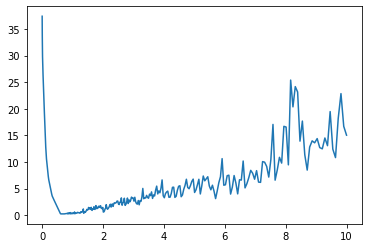

In [205]:
plt.plot(lrei, lossi)

So based on these we can see it's very stable when it's around -0.1. therefore it can be used as the learning rate

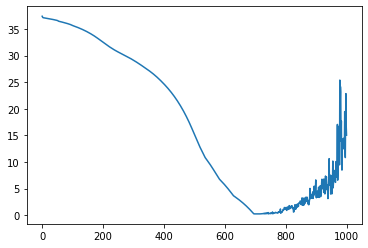

In [208]:
plt.plot(stepi, lossi)

In [ ]:
emb = C[X] 
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(7.8584, grad_fn=<NllLossBackward0>)

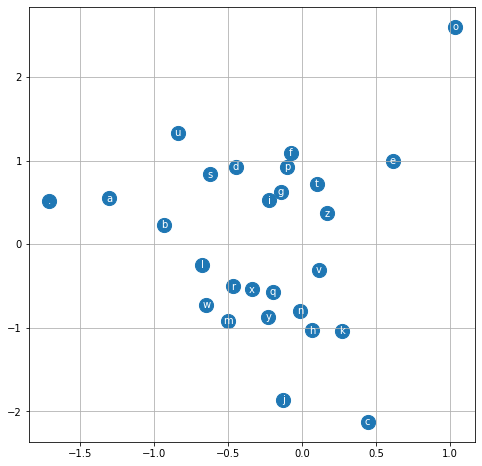

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
for _ in range(20):
    
    out = []
    context = [0] * block_size
    while True:
      emb = C[torch.tensor([context])] 
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

to.
tokaoutle.
tolmillilltlrelnebdstlilatmi.
tolmilleusssdssslatmatlt.
tosmatenrilate.
toknile.
to.
to.
to.
toknutdlt.
tommile.
tomnutlatltltllatstssstli.
tolmstnatepmate.
to.
emlutp.
ttnatelaltolqllltlelastolmitelrnatstlittlatjatlt.
ttnile.
tolmute.
to.
tolmitratle.
